In [2]:
import tensorflow as tf

In [6]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/wheat"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 14682 files belonging to 6 classes.


In [7]:
classes = training_set.class_names
classes

['wheat_brown_rust',
 'wheat_diseased',
 'wheat_healthy',
 'wheat_septoria',
 'wheat_stripe_rust',
 'wheat_yellow_rust']

In [8]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size

train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

459
367
92


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [10]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [11]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/15
367/367 [==============================] - 102s 272ms/step - loss: 0.2652 - categorical_accuracy: 0.8851 - val_loss: 0.1939 - val_categorical_accuracy: 0.9050 - lr: 0.0010
Epoch 2/15
367/367 [==============================] - 112s 305ms/step - loss: 0.1728 - categorical_accuracy: 0.9229 - val_loss: 0.1677 - val_categorical_accuracy: 0.9316 - lr: 0.0010
Epoch 3/15
367/367 [==============================] - 97s 264ms/step - loss: 0.1380 - categorical_accuracy: 0.9406 - val_loss: 0.1321 - val_categorical_accuracy: 0.9503 - lr: 0.0010
Epoch 4/15
367/367 [==============================] - 98s 266ms/step - loss: 0.1122 - categorical_accuracy: 0.9548 - val_loss: 0.1230 - val_categorical_accuracy: 0.9530 - lr: 0.0010
Epoch 5/15
367/367 [==============================] - 99s 269ms/step - loss: 0.0941 - categorical_accuracy: 0.9612 - val_loss: 0.1352 - val_categorical_accuracy: 0.9452 - lr: 0.0010
Epoch 6/15
367/367 [==============================] - 100s 271ms/step - loss: 0.0745 - c

In [13]:
train_loss,train_acc = model.evaluate(train_ds)

367/367 [==============================] - 88s 238ms/step - loss: 0.0429 - categorical_accuracy: 0.9858


In [14]:
model.save("trained_models/trained_model_wheat.keras")

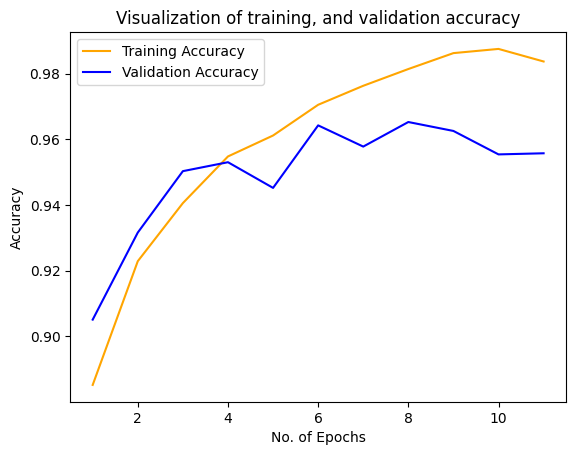

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

epochs=[i for i in range(1,12)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()
